# Overview: SVM Model Building

In [660]:
import pandas as pd
import numpy as np

# read in the full index dataset
index_data = pd.read_csv('data/index_data.csv')
index_data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
index_price = index_data[['date','Price']]
index_data

,date,Price,GDP,RATE_10,URATE,CPI,PPI,HOUSE,SAVE,Index Enterprise Value,...,SMA_60d,EMA_10d,EMA_20d,EMA_60d,MOM_10d,MOM_20d,MOM_60d,RSI_10d,RSI_20d,RSI_60d
0,2006-11-07,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2112.1243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-11-08,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2122.9425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-11-09,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2116.7542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-11-10,1.747295,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2118.6522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-11-13,1.747295,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2116.3033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,2023-10-25,29.120001,6928858.0,2.082461,3.9,129.118446,255.463,1372.0,3.8,6645.8868,...,31.056868,28.991930,29.305068,30.653225,0.170000,-0.809999,-4.557558,46.073209,38.395811,39.246621
4270,2023-10-26,29.020000,6928858.0,2.082461,3.9,129.118446,255.463,1372.0,3.8,6628.8768,...,30.976594,28.997033,29.277919,30.599677,0.620001,-0.980000,-4.816418,43.738261,37.439669,38.901081
4271,2023-10-27,28.559999,6928858.0,2.082461,3.9,129.118446,255.463,1372.0,3.8,6550.3068,...,30.889978,28.917573,29.209546,30.532802,-0.110001,-1.480001,-5.196989,34.739759,33.411001,37.362269
4272,2023-10-30,28.910000,6928858.0,2.082461,3.9,129.118446,255.463,1372.0,3.8,6609.9668,...,30.813828,28.916196,29.181018,30.479595,-0.059999,-0.750000,-4.568993,44.408773,38.694427,39.222537


### Preprocessing
- Create response variable for binary classification - we will predict whether the index will have a positive or negative return over the next 1 week, 2 weeks, and 1 month and use the most accurate model for the final stock selection model.

- Create additional technical indicators to capture shorter-term trends. These will be helpful in predicting the index return over the next 1 week.

- Creator indicator variables for economic indicators to indicate whether macro conditions are improving or worsening. For example, if the unemployment rate is increasing from the last reading, this is a negative sign for the economy and the index return is likely to be negative over the next 1 week, 2 weeks, and 1 month. This helps capture longer-term trends in the economy as opposed to the shorter-term trends captured by the technical indicators.

- Standardize the numerical columns - transform data to have mean = 0 and std = 1. Empirically, standardization has been found to work best for SVM and other models sensitive to feature scale. Use a backward-looking rolling window to standardize the data. This ensures that the model is not using future data to predict future returns (look-ahead bias).

- Split the data into train/validation and test sets. The final test set will be used to evaluate the final stock selection model and is not used in the model building process. This simulates the real-world scenario where the model is trained on historical data and then used to predict future returns. Optimizing our index model for the test set would not be realistic as we would not have access to future data in the real world.

In [661]:
# create the response variable for different time periods
response = pd.DataFrame()
response['date'] = index_data['date']
response['return_1w'] = -1 * index_data['Price'].pct_change(-5)
response['return_1w'] = response['return_1w'].map(lambda x: 1 if x > 0 else 0) # map the return to binary
response['return_2w'] = -1 * index_data['Price'].pct_change(-10)
response['return_2w'] = response['return_2w'].map(lambda x: 1 if x > 0 else 0) # map the return to binary
response['return_1m'] = -1 * index_data['Price'].pct_change(-20)
response['return_1m'] = response['return_1m'].map(lambda x: 1 if x > 0 else 0) # map the return to binary

# drop last 20 rows as they do not have a response variable
response = response.iloc[:-20]

# drop last 20 rows from index_data as well
index_data = index_data.iloc[:-20]


In [662]:
import talib as ta

# add shorter-term technical indicators
index_data['SMA_3d'] = ta.SMA(index_data['Price'], timeperiod=3)
index_data['EMA_3d'] = ta.EMA(index_data['Price'], timeperiod=3)
index_data['MOM_3d'] = ta.MOM(index_data['Price'], timeperiod=3)
index_data['RSI_3d'] = ta.RSI(index_data['Price'], timeperiod=3)
index_data['SMA_5d'] = ta.SMA(index_data['Price'], timeperiod=5)
index_data['EMA_5d'] = ta.EMA(index_data['Price'], timeperiod=5)
index_data['MOM_5d'] = ta.MOM(index_data['Price'], timeperiod=5)
index_data['RSI_5d'] = ta.RSI(index_data['Price'], timeperiod=5)

index_data

/var/folders/4r/nslfysrs2yl8s28sy4rz2_vr0000gn/T/ipykernel_45067/1792982454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_data['SMA_3d'] = ta.SMA(index_data['Price'], timeperiod=3)
/var/folders/4r/nslfysrs2yl8s28sy4rz2_vr0000gn/T/ipykernel_45067/1792982454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_data['EMA_3d'] = ta.EMA(index_data['Price'], timeperiod=3)
/var/folders/4r/nslfysrs2yl8s28sy4rz2_vr0000gn/T/ipykernel_45067/1792982454.py:6: SettingWithCopyWarning: 
A value is trying t

,date,Price,GDP,RATE_10,URATE,CPI,PPI,HOUSE,SAVE,Index Enterprise Value,...,RSI_20d,RSI_60d,SMA_3d,EMA_3d,MOM_3d,RSI_3d,SMA_5d,EMA_5d,MOM_5d,RSI_5d
0,2006-11-07,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2112.1243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-11-08,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2122.9425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-11-09,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2116.7542,...,NaN,NaN,1.743284,1.743284,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-11-10,1.747295,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2118.6522,...,NaN,NaN,1.744621,1.745290,0.004011,100.000000,NaN,NaN,NaN,NaN
4,2006-11-13,1.747295,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2116.3033,...,NaN,NaN,1.745958,1.746292,0.004011,100.000000,1.744888,1.744888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249,2023-09-27,29.930000,6928858.0,1.699708,3.8,129.118446,258.889,1346.0,3.7,6799.8725,...,24.344941,37.778915,30.226667,30.198428,-0.680000,2.662759,30.440000,30.402667,-1.360001,8.104238
4250,2023-09-28,30.000000,6928858.0,1.699708,3.8,129.118446,258.889,1346.0,3.7,6811.0825,...,25.802704,38.188448,30.063334,30.099214,-0.490000,14.632058,30.258000,30.268445,-0.910000,14.700976
4251,2023-09-29,30.040001,6928858.0,1.699708,3.8,129.118446,258.889,1346.0,3.7,6816.9425,...,26.652829,38.423972,29.990000,30.069607,-0.219999,22.772139,30.144000,30.192297,-0.570000,18.861468
4252,2023-10-02,29.660000,6928858.0,2.082461,3.9,129.118446,255.463,1372.0,3.8,6750.3425,...,23.913021,37.059758,29.900000,29.864804,-0.270000,9.654319,29.978000,30.014865,-0.830000,11.943716


In [663]:
macro_cols = ['GDP','RATE_10','URATE','CPI','PPI','HOUSE','SAVE']
# create function to implement the above steps for all economic indicators
def create_indicator_change_df(indicator_name):

    # calculate indicator change over 1 day and map to 1, -1, or 0
    # 1 indicates the indicator has increased over the past 1 day, -1 indicates the indicator has decreased over the past 1 day, and 0 indicates the indicator has not changed over the past 1 day
    indicator_change_1d = index_data[indicator_name].pct_change(1)
    indicator_change_1d = indicator_change_1d.map(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # create indicator change columns, indicating if the metric has increased/decreased/unchanged over the past 1-5 days
    indicator_change_minus_1 = indicator_change_1d.shift(1)
    indicator_change_minus_2 = indicator_change_1d.shift(2)
    indicator_change_minus_3 = indicator_change_1d.shift(3)
    indicator_change_minus_4 = indicator_change_1d.shift(4)
    indicator_change_minus_5 = indicator_change_1d.shift(5)

    # create dataframe with indicator change columns
    indicator_change = pd.DataFrame()
    indicator_change['date'] = index_data['date']
    indicator_change[indicator_name + '_change_1d'] = indicator_change_1d
    indicator_change[indicator_name + '_change_minus_1'] = indicator_change_minus_1
    indicator_change[indicator_name + '_change_minus_2'] = indicator_change_minus_2
    indicator_change[indicator_name + '_change_minus_3'] = indicator_change_minus_3
    indicator_change[indicator_name + '_change_minus_4'] = indicator_change_minus_4
    indicator_change[indicator_name + '_change_minus_5'] = indicator_change_minus_5

    # return dataframe
    return indicator_change

# add the indicator change columns to the index_data dataframe
for col in macro_cols:
    indicator_change = create_indicator_change_df(col)
    index_data = pd.merge(index_data, indicator_change, on='date', how='left')

index_data


,date,Price,GDP,RATE_10,URATE,CPI,PPI,HOUSE,SAVE,Index Enterprise Value,...,HOUSE_change_minus_2,HOUSE_change_minus_3,HOUSE_change_minus_4,HOUSE_change_minus_5,SAVE_change_1d,SAVE_change_minus_1,SAVE_change_minus_2,SAVE_change_minus_3,SAVE_change_minus_4,SAVE_change_minus_5
0,2006-11-07,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2112.1243,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2006-11-08,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2122.9425,...,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN
2,2006-11-09,1.743284,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2116.7542,...,0.0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN
3,2006-11-10,1.747295,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2118.6522,...,0.0,0.0,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN
4,2006-11-13,1.747295,3557633.0,2.199885,4.5,85.366591,164.600,1570.0,2.7,2116.3033,...,0.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249,2023-09-27,29.930000,6928858.0,1.699708,3.8,129.118446,258.889,1346.0,3.7,6799.8725,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4250,2023-09-28,30.000000,6928858.0,1.699708,3.8,129.118446,258.889,1346.0,3.7,6811.0825,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4251,2023-09-29,30.040001,6928858.0,1.699708,3.8,129.118446,258.889,1346.0,3.7,6816.9425,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4252,2023-10-02,29.660000,6928858.0,2.082461,3.9,129.118446,255.463,1372.0,3.8,6750.3425,...,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0


In [664]:
# standardize the numerical columns - transform data to have mean = 0 and std = 1
# empirically, standardization has been found to work best for SVM and other models sensitive to feature scale

# SVM is sensitive to the scale of the input features because it aims to maximize the margin between the classes so it
#  is important to keep other feature variables on the same scale. So, we will also standardize the other continuous features in the dataset.

# Assuming 'index_data' is your DataFrame with features and 'num_cols' are the columns you want to standardize
num_cols = ['Price', 'GDP', 'RATE_10', 'URATE', 'CPI', 'PPI', 'HOUSE', 'SAVE', 'Index Enterprise Value',
            'Adjusted Price/Earnings ratio','Adjusted Price/Estimated Earnings', 'BEst Div Yld', 'Total Debt to Total Equity', 'Current Market Cap',
            'Profit Margin',  'SMA_10d', 'SMA_20d', 'SMA_60d', 'EMA_10d', 'EMA_20d', 'EMA_60d','MOM_10d', 'MOM_20d', 'MOM_60d', 'RSI_10d', 'RSI_20d', 'RSI_60d','SMA_3d', 'EMA_3d', 'MOM_3d', 'RSI_3d', 'SMA_5d', 'EMA_5d', 'MOM_5d','RSI_5d']


# use a backward-looking rolling window to standardize the data
# using different window sizes to capture different trends
window_size_lst = [5,10,20]

# Standardize using a rolling window
standardized_df = pd.DataFrame()

# for each numerical column
for col in num_cols:
    # for each window size
    for window_size in window_size_lst:
        # calculate the rolling mean and standard deviation
        rolling_means = index_data[col].rolling(window=window_size).mean()
        rolling_stds = index_data[col].rolling(window=window_size).std()

        # Standardize the numerical columns using the rolling mean and standard deviation
        name = col + '_standardized_' + str(window_size)
        standardized = pd.DataFrame((index_data[col] - rolling_means) / rolling_stds)
        standardized.rename(columns={col: name}, inplace=True)
        standardized_df = pd.concat([standardized_df, standardized], axis=1)

        # fill nan values with the last value
        standardized_df.fillna(method='ffill', inplace=True)

        # fill infinite values with 0
        standardized_df.fillna(0, inplace=True)


# drop numerical columns from index_data and add standardized columns
index_data.drop(num_cols, axis=1, inplace=True)
standardized_df = pd.concat([index_data, standardized_df], axis=1)

In [665]:
# drop rows with nan values
# standardized_df is the final dataset to be used in training the models
standardized_df.dropna(inplace=True)
standardized_df

,date,GDP_change_1d,GDP_change_minus_1,GDP_change_minus_2,GDP_change_minus_3,GDP_change_minus_4,GDP_change_minus_5,RATE_10_change_1d,RATE_10_change_minus_1,RATE_10_change_minus_2,...,SMA_5d_standardized_20,EMA_5d_standardized_5,EMA_5d_standardized_10,EMA_5d_standardized_20,MOM_5d_standardized_5,MOM_5d_standardized_10,MOM_5d_standardized_20,RSI_5d_standardized_5,RSI_5d_standardized_10,RSI_5d_standardized_20
5,2006-11-14,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2006-11-15,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2006-11-16,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2006-11-17,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.000000,1.008289,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,2006-11-20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.000000,1.008289,0.000000,0.000000,-1.095445,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249,2023-09-27,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,-2.200007,-1.334137,-1.872534,-2.194755,-1.680651,-1.658305,-1.898226,-1.168789,-1.293617,-1.549522
4250,2023-09-28,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,-2.198684,-1.200958,-1.654430,-2.150945,0.288086,-0.665298,-0.901758,0.429108,-0.746099,-0.986320
4251,2023-09-29,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,-2.105164,-1.036507,-1.434840,-2.027824,1.278505,0.195401,-0.131163,1.304002,-0.279608,-0.594680
4252,2023-10-02,0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,...,-2.100804,-1.232515,-1.438782,-2.054254,0.336417,-0.292648,-0.633031,-0.265082,-0.734192,-1.060368


In [666]:
# split the data into train/validation and test sets
# split roughly in half - 2006-2014 for train/validation and 2015-2023 for test
# this ensures that there is enough data in the train/validation set to train the model
# and that the test set is large enough to train and evaluate the final stock selection model

final_test_data = standardized_df[standardized_df['date'] >= '2015']
final_response = response[response['date'] >= '2015']

standardized_df = standardized_df[standardized_df['date'] < '2015']
response = response[response['date'] < '2015']

# save final_test_data for use in the final stock selection model
final_test_data.to_csv('data/final_test_data.csv')

## Model Building: Approach 1
- Binary classification predicting positive/negative return over the next 1 week
- Test SVM with Poly and RBF kernels (linear kernel is not used as it is not suitable for non-linear data)
- Use 80/20 train/test split

In [116]:
# select the response variable as the index return over the next 1 week
y = response[response['date'] >= '2006-11-14']['return_1w'].values

# select the features and drop the date column
X = standardized_df.drop(['date'], axis=1).values

# replace infinite values with large finite values to avoid errors while capturing the trends
X = np.nan_to_num(X, posinf=3, neginf=-3)

In [117]:
# spit svm dataset into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=123)

In [118]:
# fit SVMs
# using multiple c values to find best model
from sklearn import svm
model_dict_1w = {}
c_list = [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 10, 25]
kern_list = ['poly', 'rbf']
for c in c_list:
    for k in kern_list:
        print("Training Model: ", c, k)
        name = str(c) + "_" + k
        mod = svm.SVC(C=c, kernel=k)
        mod.fit(x_train, y_train)
        model_dict_1w["mod_"+name] = mod

Training Model:  0.01 poly
Training Model:  0.01 rbf
Training Model:  0.1 poly
Training Model:  0.1 rbf


KeyboardInterrupt: 

In [82]:
# separate SVM models into different dictionaries based on kernel type
model_dict_poly_1w = {}
model_dict_rbf_1w = {}
for key, model in model_dict_1w.items():
    if 'poly' in key:
        model_dict_poly_1w[key] = model
    elif 'rbf' in key:
        model_dict_rbf_1w[key] = model

In [83]:
# analyze poly results
from sklearn.metrics import precision_score, recall_score
poly_results_1w = {}
print("Model, Accuracy, Precision, Recall\n")
for key, model in model_dict_poly_1w.items():
       acc = model.score(x_test, y_test)
       preds = model.predict(x_test)
       precision = precision_score(y_test, preds)
       recall = recall_score(y_test, preds)
       poly_results_1w[key] = [acc, precision, recall]
       print(key, " ", acc, precision, recall)

Model, Accuracy, Precision, Recall

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [359]:
# create results dataframe
poly_results_df_1w = pd.DataFrame.from_dict(poly_results_1w).transpose()
poly_results_df_1w.rename(columns={0:'Accuracy',1:'Precision',2:'Recall'}, inplace=True)
poly_results_df_1w['c'] = ['0.01', '0.1', '0.15', '0.25', '0.5', '0.75', '1', '10', '25']
poly_results_df_1w.set_index('c', inplace=True)
poly_results_df_1w

,Accuracy,Precision,Recall
c,,,
0.01,0.605932,0.605932,1.000000
0.1,0.604520,0.605375,0.997669
0.15,0.604520,0.605674,0.995338
0.25,0.600282,0.603989,0.988345
0.5,0.594633,0.603198,0.967366
0.75,0.583333,0.598240,0.951049
1,0.587571,0.603008,0.934732
10,0.531073,0.596040,0.701632
25,0.501412,0.582251,0.627040


<Axes: xlabel='c'>

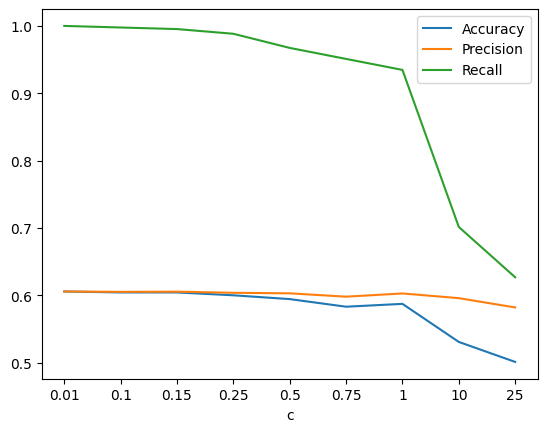

In [360]:
# plot results dataframe
poly_results_df_1w['Accuracy'].transpose().plot(legend=True)
poly_results_df_1w['Precision'].transpose().plot(legend=True)
poly_results_df_1w['Recall'].transpose().plot(legend=True)

In [361]:
# analyze rbf results
rbf_results_1w = {}
print("Model, Accuracy, Precision, Recall\n")
for key, model in model_dict_rbf_1w.items():
       acc = model.score(x_test, y_test)
       preds = model.predict(x_test)
       precision = precision_score(y_test, preds)
       recall = recall_score(y_test, preds)
       rbf_results_1w[key] = [acc, precision, recall]
       print(key, " ", acc, precision, recall)

Model, Accuracy, Precision, Recall

mod_0.01_rbf   0.6059322033898306 0.6059322033898306 1.0
mod_0.1_rbf   0.6059322033898306 0.6059322033898306 1.0
mod_0.15_rbf   0.6059322033898306 0.6059322033898306 1.0
mod_0.25_rbf   0.6059322033898306 0.6059322033898306 1.0
mod_0.5_rbf   0.6045197740112994 0.6056737588652482 0.9953379953379954
mod_0.75_rbf   0.5861581920903954 0.5997067448680352 0.9533799533799534
mod_1_rbf   0.5677966101694916 0.5947611710323575 0.8997668997668997
mod_10_rbf   0.5310734463276836 0.6008316008316008 0.6736596736596736
mod_25_rbf   0.5282485875706214 0.6021505376344086 0.6526806526806527


In [362]:
# create results dataframe
rbf_results_df_1w = pd.DataFrame.from_dict(rbf_results_1w).transpose()
rbf_results_df_1w.rename(columns={0:'Accuracy',1:'Precision',2:'Recall'}, inplace=True)
rbf_results_df_1w['c'] = ['0.01', '0.1', '0.15', '0.25', '0.5', '0.75', '1', '10', '25']
rbf_results_df_1w.set_index('c', inplace=True)
rbf_results_df_1w

,Accuracy,Precision,Recall
c,,,
0.01,0.605932,0.605932,1.000000
0.1,0.605932,0.605932,1.000000
0.15,0.605932,0.605932,1.000000
0.25,0.605932,0.605932,1.000000
0.5,0.604520,0.605674,0.995338
0.75,0.586158,0.599707,0.953380
1,0.567797,0.594761,0.899767
10,0.531073,0.600832,0.673660
25,0.528249,0.602151,0.652681


<Axes: xlabel='c'>

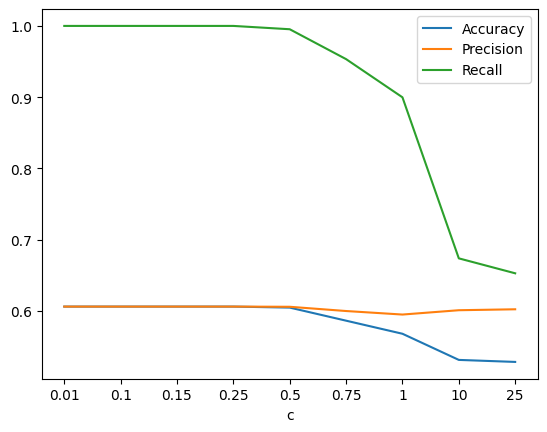

In [363]:
# plot results dataframe
rbf_results_df_1w['Accuracy'].transpose().plot(legend=True)
rbf_results_df_1w['Precision'].transpose().plot(legend=True)
rbf_results_df_1w['Recall'].transpose().plot(legend=True)

In [364]:
# perform cross validation to ensure consistent results across different train/test splits
from sklearn.model_selection import cross_val_score, KFold

# cross validation
for c in [0.001, 0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 1.25, 1.5]:
    print("Cross Validation for C = ", c)
    mod = svm.SVC(C=c, kernel='rbf')
    scores = cross_val_score(mod, x_train, y_train, cv=KFold(10, shuffle=False), scoring='accuracy')
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    print("\n")


Cross Validation for C =  0.001
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.58303887 0.59363958 0.62765957]
Mean: 0.6062288549733102
Standard Deviation: 0.05725863369068064


Cross Validation for C =  0.01
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.58303887 0.59363958 0.62765957]
Mean: 0.6062288549733102
Standard Deviation: 0.05725863369068064


Cross Validation for C =  0.1
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.58303887 0.59363958 0.62765957]
Mean: 0.6062288549733102
Standard Deviation: 0.05725863369068064


Cross Validation for C =  0.15
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.58303887 0.59363958 0.62765957]
Mean: 0.6062288549733102
Standard Deviation: 0.05725863369068064


Cross Validation for C =  0.25
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.5830

## Model Building: Approach 2
- Binary classification predicting positive/negative return over the next 2 weeks
- Test SVM with Poly and RBF kernels (linear kernel is not used as it is not suitable for non-linear data)
- Use 80/20 train/test split

In [365]:
# select the response variable as the index return over the next 2 weeks
y = response[response['date'] >= '2006-11-14']['return_1w'].values

# select the features and drop the date column
X = standardized_df.drop(['date'], axis=1).values

# replace infinite values
X = np.nan_to_num(X, posinf=3, neginf=-3)

In [284]:
# spit svm dataset into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=123)

In [285]:
# fit SVMs
# using multiple c values to find best model
from sklearn import svm
model_dict_2w = {}
c_list = [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 10, 25]
kern_list = ['poly', 'rbf']
for c in c_list:
    for k in kern_list:
        print("Training Model: ", c, k)
        name = str(c) + "_" + k
        mod = svm.SVC(C=c, kernel=k)
        mod.fit(x_train, y_train)
        model_dict_2w["mod_"+name] = mod

Training Model:  0.01 poly
Training Model:  0.01 rbf
Training Model:  0.1 poly
Training Model:  0.1 rbf
Training Model:  0.15 poly
Training Model:  0.15 rbf
Training Model:  0.25 poly
Training Model:  0.25 rbf
Training Model:  0.5 poly
Training Model:  0.5 rbf
Training Model:  0.75 poly
Training Model:  0.75 rbf
Training Model:  1 poly
Training Model:  1 rbf
Training Model:  10 poly
Training Model:  10 rbf
Training Model:  25 poly
Training Model:  25 rbf


In [286]:
# separate SVM models into different dictionaries based on kernel type
model_dict_poly_2w = {}
model_dict_rbf_2w = {}
for key, model in model_dict_2w.items():
    if 'poly' in key:
        model_dict_poly_2w[key] = model
    elif 'rbf' in key:
        model_dict_rbf_2w[key] = model

In [287]:
# analyze poly results
from sklearn.metrics import precision_score, recall_score
poly_results_2w = {}
print("Model, Accuracy, Precision, Recall\n")
for key, model in model_dict_poly_2w.items():
       acc = model.score(x_test, y_test)
       preds = model.predict(x_test)
       precision = precision_score(y_test, preds)
       recall = recall_score(y_test, preds)
       poly_results_2w[key] = [acc, precision, recall]
       print(key, " ", acc, precision, recall)

Model, Accuracy, Precision, Recall

mod_0.01_poly   0.6059322033898306 0.6059322033898306 1.0
mod_0.1_poly   0.6045197740112994 0.6053748231966054 0.9976689976689976
mod_0.15_poly   0.6045197740112994 0.6056737588652482 0.9953379953379954
mod_0.25_poly   0.6002824858757062 0.603988603988604 0.9883449883449883
mod_0.5_poly   0.594632768361582 0.6031976744186046 0.9673659673659674
mod_0.75_poly   0.5833333333333334 0.5982404692082112 0.951048951048951
mod_1_poly   0.5875706214689266 0.6030075187969924 0.9347319347319347
mod_10_poly   0.5310734463276836 0.596039603960396 0.7016317016317016
mod_25_poly   0.501412429378531 0.5822510822510822 0.627039627039627


In [288]:
# analyze poly results
# plot results dataframe
# create results dataframe
poly_results_df_2w = pd.DataFrame.from_dict(poly_results_2w).transpose()
poly_results_df_2w.rename(columns={0:'Accuracy',1:'Precision',2:'Recall'}, inplace=True)
poly_results_df_2w['c'] = ['0.01', '0.1', '0.15', '0.25', '0.5', '0.75', '1', '10', '25']
poly_results_df_2w.set_index('c', inplace=True)
poly_results_df_2w

,Accuracy,Precision,Recall
c,,,
0.01,0.605932,0.605932,1.000000
0.1,0.604520,0.605375,0.997669
0.15,0.604520,0.605674,0.995338
0.25,0.600282,0.603989,0.988345
0.5,0.594633,0.603198,0.967366
0.75,0.583333,0.598240,0.951049
1,0.587571,0.603008,0.934732
10,0.531073,0.596040,0.701632
25,0.501412,0.582251,0.627040


<Axes: xlabel='c'>

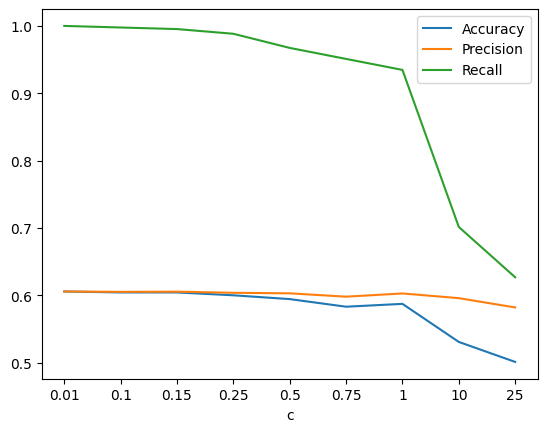

In [289]:
# plot results dataframe
poly_results_df_2w['Accuracy'].transpose().plot(legend=True)
poly_results_df_2w['Precision'].transpose().plot(legend=True)
poly_results_df_2w['Recall'].transpose().plot(legend=True)

In [290]:
# analyze rbf results
rbf_results_2w = {}
print("Model, Accuracy, Precision, Recall\n")
for key, model in model_dict_rbf_2w.items():
       acc = model.score(x_test, y_test)
       preds = model.predict(x_test)
       precision = precision_score(y_test, preds)
       recall = recall_score(y_test, preds)
       rbf_results_2w[key] = [acc, precision, recall]
       print(key, " ", acc, precision, recall)

Model, Accuracy, Precision, Recall

mod_0.01_rbf   0.6059322033898306 0.6059322033898306 1.0
mod_0.1_rbf   0.6059322033898306 0.6059322033898306 1.0
mod_0.15_rbf   0.6059322033898306 0.6059322033898306 1.0
mod_0.25_rbf   0.6059322033898306 0.6059322033898306 1.0
mod_0.5_rbf   0.6045197740112994 0.6056737588652482 0.9953379953379954
mod_0.75_rbf   0.5861581920903954 0.5997067448680352 0.9533799533799534
mod_1_rbf   0.5677966101694916 0.5947611710323575 0.8997668997668997
mod_10_rbf   0.5310734463276836 0.6008316008316008 0.6736596736596736
mod_25_rbf   0.5282485875706214 0.6021505376344086 0.6526806526806527


In [291]:
# create results dataframe
rbf_results_df_2w = pd.DataFrame.from_dict(rbf_results_2w).transpose()
rbf_results_df_2w.rename(columns={0:'Accuracy',1:'Precision',2:'Recall'}, inplace=True)
rbf_results_df_2w['c'] = ['0.01', '0.1', '0.15', '0.25', '0.5', '0.75', '1', '10', '25']
rbf_results_df_2w.set_index('c', inplace=True)
rbf_results_df_2w

,Accuracy,Precision,Recall
c,,,
0.01,0.605932,0.605932,1.000000
0.1,0.605932,0.605932,1.000000
0.15,0.605932,0.605932,1.000000
0.25,0.605932,0.605932,1.000000
0.5,0.604520,0.605674,0.995338
0.75,0.586158,0.599707,0.953380
1,0.567797,0.594761,0.899767
10,0.531073,0.600832,0.673660
25,0.528249,0.602151,0.652681


<Axes: xlabel='c'>

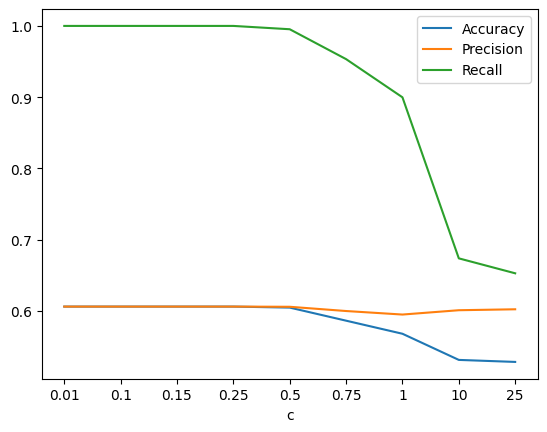

In [292]:
# plot results dataframe
rbf_results_df_2w['Accuracy'].transpose().plot(legend=True)
rbf_results_df_2w['Precision'].transpose().plot(legend=True)
rbf_results_df_2w['Recall'].transpose().plot(legend=True)

In [293]:
# cross validation
for c in [0.001, 0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 1.25, 1.5]:
    print("Cross Validation for C = ", c)
    mod = svm.SVC(C=c, kernel='rbf')
    scores = cross_val_score(mod, x_train, y_train, cv=KFold(10, shuffle=False), scoring='accuracy')
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    print("\n")

Cross Validation for C =  0.001
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.58303887 0.59363958 0.62765957]
Mean: 0.6062288549733102
Standard Deviation: 0.05725863369068064


Cross Validation for C =  0.01
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.58303887 0.59363958 0.62765957]
Mean: 0.6062288549733102
Standard Deviation: 0.05725863369068064


Cross Validation for C =  0.1
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.58303887 0.59363958 0.62765957]
Mean: 0.6062288549733102
Standard Deviation: 0.05725863369068064


Cross Validation for C =  0.15
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.58303887 0.59363958 0.62765957]
Mean: 0.6062288549733102
Standard Deviation: 0.05725863369068064


Cross Validation for C =  0.25
Scores: [0.58657244 0.46996466 0.66784452 0.64664311 0.57243816 0.67844523
 0.6360424  0.5830

## Model Building: Approach 3
- Binary classification predicting positive/negative return over the next 1 month
- Test SVM with Poly and RBF kernels (linear kernel is not used as it is not suitable for non-linear data)
- Use 80/20 train/test split

In [667]:
# select the response variable as the index return over the next 1 month
y = response[response['date'] >= '2006-11-14']['return_1m'].values

# select the features and drop the date column
X = standardized_df.drop(['date'], axis=1).values

# replace infinite values
X = np.nan_to_num(X, posinf=3, neginf=-3)

In [668]:
# spit svm dataset into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=123)

In [669]:
# fit SVMs
# using multiple c values to find best model
from sklearn import svm
model_dict_1m = {}
c_list = [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 10, 25]
kern_list = ['poly', 'rbf']
for c in c_list:
    for k in kern_list:
        print("Training Model: ", c, k)
        name = str(c) + "_" + k
        mod = svm.SVC(C=c, kernel=k)
        mod.fit(x_train, y_train)
        model_dict_1m["mod_"+name] = mod

Training Model:  0.01 poly
Training Model:  0.01 rbf
Training Model:  0.1 poly
Training Model:  0.1 rbf
Training Model:  0.15 poly
Training Model:  0.15 rbf
Training Model:  0.25 poly
Training Model:  0.25 rbf
Training Model:  0.5 poly
Training Model:  0.5 rbf
Training Model:  0.75 poly
Training Model:  0.75 rbf
Training Model:  1 poly
Training Model:  1 rbf
Training Model:  10 poly
Training Model:  10 rbf
Training Model:  25 poly
Training Model:  25 rbf


In [670]:
# separate SVM models into different dictionaries based on kernel type
model_dict_poly_1m = {}
model_dict_rbf_1m = {}
for key, model in model_dict_1m.items():
    if 'poly' in key:
        model_dict_poly_1m[key] = model
    elif 'rbf' in key:
        model_dict_rbf_1m[key] = model

In [671]:
# analyze poly results
from sklearn.metrics import precision_score, recall_score
poly_results_1m = {}
print("Model, Accuracy, Precision, Recall\n")
for key, model in model_dict_poly_1m.items():
       acc = model.score(x_test, y_test)
       preds = model.predict(x_test)
       precision = precision_score(y_test, preds)
       recall = recall_score(y_test, preds)
       poly_results_1m[key] = [acc, precision, recall]
       print(key, " ", acc, precision, recall)

Model, Accuracy, Precision, Recall

mod_0.01_poly   0.7902439024390244 0.7902439024390244 1.0
mod_0.1_poly   0.7878048780487805 0.7897310513447433 0.9969135802469136
mod_0.15_poly   0.7853658536585366 0.7892156862745098 0.9938271604938271
mod_0.25_poly   0.7829268292682927 0.7886977886977887 0.9907407407407407
mod_0.5_poly   0.7804878048780488 0.7881773399014779 0.9876543209876543
mod_0.75_poly   0.7658536585365854 0.785 0.9691358024691358
mod_1_poly   0.7463414634146341 0.7806122448979592 0.9444444444444444
mod_10_poly   0.6024390243902439 0.784452296819788 0.6851851851851852
mod_25_poly   0.5829268292682926 0.7931034482758621 0.6388888888888888


In [672]:
# create results dataframe
poly_results_df_1m = pd.DataFrame.from_dict(poly_results_1m).transpose()
poly_results_df_1m.rename(columns={0:'Accuracy',1:'Precision',2:'Recall'}, inplace=True)
poly_results_df_1m['c'] = ['0.01', '0.1', '0.15', '0.25', '0.5', '0.75', '1', '10', '25']
poly_results_df_1m.set_index('c', inplace=True)
poly_results_df_1m

,Accuracy,Precision,Recall
c,,,
0.01,0.790244,0.790244,1.000000
0.1,0.787805,0.789731,0.996914
0.15,0.785366,0.789216,0.993827
0.25,0.782927,0.788698,0.990741
0.5,0.780488,0.788177,0.987654
0.75,0.765854,0.785000,0.969136
1,0.746341,0.780612,0.944444
10,0.602439,0.784452,0.685185
25,0.582927,0.793103,0.638889


<Axes: xlabel='c'>

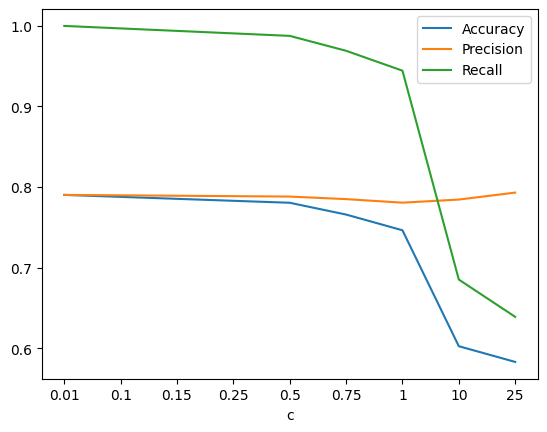

In [673]:
# plot results dataframe
poly_results_df_1m['Accuracy'].transpose().plot(legend=True)
poly_results_df_1m['Precision'].transpose().plot(legend=True)
poly_results_df_1m['Recall'].transpose().plot(legend=True)


In [674]:
# analyze rbf results
rbf_results_1m = {}
print("Model, Accuracy, Precision, Recall\n")
for key, model in model_dict_rbf_1m.items():
       acc = model.score(x_test, y_test)
       preds = model.predict(x_test)
       precision = precision_score(y_test, preds)
       recall = recall_score(y_test, preds)
       rbf_results_1m[key] = [acc, precision, recall]
       print(key, " ", acc, precision, recall)

Model, Accuracy, Precision, Recall

mod_0.01_rbf   0.7902439024390244 0.7902439024390244 1.0
mod_0.1_rbf   0.7902439024390244 0.7902439024390244 1.0
mod_0.15_rbf   0.7902439024390244 0.7902439024390244 1.0
mod_0.25_rbf   0.7902439024390244 0.7902439024390244 1.0
mod_0.5_rbf   0.7853658536585366 0.7892156862745098 0.9938271604938271
mod_0.75_rbf   0.7829268292682927 0.7886977886977887 0.9907407407407407
mod_1_rbf   0.7829268292682927 0.7886977886977887 0.9907407407407407
mod_10_rbf   0.624390243902439 0.8102189781021898 0.6851851851851852
mod_25_rbf   0.6097560975609756 0.8129770992366412 0.6574074074074074


In [675]:
# create results dataframe
rbf_results_df_1m = pd.DataFrame.from_dict(rbf_results_1m).transpose()
rbf_results_df_1m.rename(columns={0:'Accuracy',1:'Precision',2:'Recall'}, inplace=True)
rbf_results_df_1m['c'] = ['0.01', '0.1', '0.15', '0.25', '0.5', '0.75', '1', '10', '25']
rbf_results_df_1m.set_index('c', inplace=True)
rbf_results_df_1m

,Accuracy,Precision,Recall
c,,,
0.01,0.790244,0.790244,1.000000
0.1,0.790244,0.790244,1.000000
0.15,0.790244,0.790244,1.000000
0.25,0.790244,0.790244,1.000000
0.5,0.785366,0.789216,0.993827
0.75,0.782927,0.788698,0.990741
1,0.782927,0.788698,0.990741
10,0.624390,0.810219,0.685185
25,0.609756,0.812977,0.657407


<Axes: xlabel='c'>

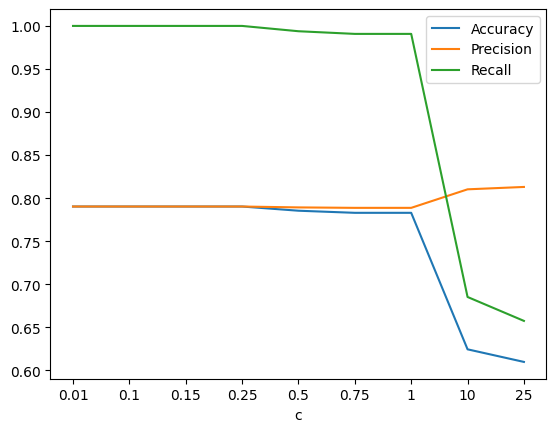

In [676]:
# plot results dataframe
rbf_results_df_1m['Accuracy'].transpose().plot(legend=True)
rbf_results_df_1m['Precision'].transpose().plot(legend=True)
rbf_results_df_1m['Recall'].transpose().plot(legend=True)

In [679]:
# cross validation
for c in [0.001, 0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 2.5]:
    print("Cross Validation for C = ", c)
    mod = svm.SVC(C=c, kernel='rbf')
    scores = cross_val_score(mod, x_train, y_train, cv=KFold(10, shuffle=False), scoring='accuracy')
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    print("\n")

Cross Validation for C =  0.001
Scores: [0.76829268 0.59146341 0.4695122  0.70731707 0.89634146 0.67073171
 0.74846626 0.71779141 0.78527607 0.80981595]
Mean: 0.71650082298369
Standard Deviation: 0.11327097798213868


Cross Validation for C =  0.01
Scores: [0.76829268 0.59146341 0.4695122  0.70731707 0.89634146 0.67073171
 0.74846626 0.71779141 0.78527607 0.80981595]
Mean: 0.71650082298369
Standard Deviation: 0.11327097798213868


Cross Validation for C =  0.1
Scores: [0.76829268 0.59146341 0.4695122  0.70731707 0.89634146 0.67073171
 0.74846626 0.71779141 0.78527607 0.80981595]
Mean: 0.71650082298369
Standard Deviation: 0.11327097798213868


Cross Validation for C =  0.15
Scores: [0.76829268 0.59146341 0.4695122  0.70731707 0.89634146 0.67073171
 0.74846626 0.71779141 0.78527607 0.80981595]
Mean: 0.71650082298369
Standard Deviation: 0.11327097798213868


Cross Validation for C =  0.25
Scores: [0.76829268 0.59146341 0.4695122  0.70731707 0.89634146 0.67073171
 0.74846626 0.71779141 0.7

# Model Building Conclusion
- The models predicting 1-month positive/negative return performed the best, with the highest accuracy and comparable precision and recall scores. This is likely because the 1-month return is easier to predict than the 1-week and 2-week returns, which are more volatile and harder to predict. Additionally, the macroeconomic indicators are more likely to have an impact on the index return over the next 1 month than over the next 1 week or 2 weeks.

- As a result, we will use the model predicting 1-month positive/negative return to predict the index return over the next 1 month and use the predictions to select stocks for the final stock selection model.

- The rbf kernel slighlty performed better than the poly kernel, although they are very similar indicating that kernel choice is not very important for this dataset.

- As C increases in our models, the accuracy and recall slowly decrease up to a certain point (a little after C=1) and then drop off sharply. This is likely because as C increases, the model is overfitting to the training data and is not able to generalize well to the test data. This is why we see a sharp drop in accuracy and recall as C increases past a certain point. On the other hand precision increases as C increases.

- We choose C=1.5 as it maintains a relatively high accuracy and recall, while also having some improvement in precision over smaller Cs. This helps to ensure that we don't underfit the data and that we are able to capture as many positive returns as possible on the unseen test set.

- Next, we train the final model using the entire train/validation dataset and use the final model to predict the index return over the next 1 month on the unseen test set. We will use these predictions to select stocks for the final stock selection model.

## Train and Fit Best Model

In [649]:
# follow the same steps as above to train and fit the best model
x = standardized_df.drop(['date'], axis=1).values
y = response[response['date'] >= '2006-11-14']['return_1m'].values

# replace infinite values
x = np.nan_to_num(x, posinf=3, neginf=-3)

In [650]:
# fit final model
final_mod = svm.SVC(C=1.5, kernel='rbf')
final_mod.fit(x, y)

SVC(C=1.5)

In [651]:
# predict index return over the next 1 month on the unseen test set
final_test_data = final_test_data.drop(['date'], axis=1).values
final_test_data = np.nan_to_num(final_test_data, posinf=3, neginf=-3)
final_index_predictions = pd.DataFrame(final_mod.predict(final_test_data))

# add date column
final_index_predictions['date'] = final_response['date'].values
final_index_predictions.rename(columns={0:'prediction'}, inplace=True)
final_index_predictions.set_index('date', inplace=True)
final_index_predictions

,prediction
date,
2015-01-02,0
2015-01-05,0
2015-01-06,0
2015-01-07,0
2015-01-08,0
...,...
2023-09-27,1
2023-09-28,1
2023-09-29,1


In [655]:
# save final_index_predictions for use in the final stock selection model
final_index_predictions.to_csv('data/final_index_predictions.csv')